# Imports and Loading

In [13]:
#base
import pandas as pd
import numpy as np
import re
import math

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#warning
import warnings
warnings.filterwarnings('ignore')

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import  confusion_matrix, classification_report,auc,fbeta_score,f1_score,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,accuracy_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler 
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV,train_test_split as split,learning_curve
from sklearn.pipeline import Pipeline

In [14]:
df=pd.read_csv('weatherAUS.csv',parse_dates=['Date'])
df.rename(lambda col: col.lower(),axis=1,inplace=True)
df.rename(lambda col: col.strip(),axis=1,inplace=True)

# add underscore to each column i choose convinevincy
df.rename(columns={'mintemp':'min_temp',
         'maxtemp':'max_temp',
         'windgustdir':'wind_direction',
         'windgustspeed':'wind_speed','raintoday':'rain_today',
                   'raintomorrow':'rain_tomorrow'},inplace=True)

df.drop(columns=['date','location','cloud3pm','cloud9am','evaporation','sunshine','winddir9am','winddir3pm'],inplace=True)


In [43]:
def features_explantory(df):
    print(df.shape)
    table=pd.DataFrame(df.dtypes,columns=['type']).reset_index().rename({'index':'features'},axis=1)
    table['%_nulls']=df.isnull().sum().values/len(df)
    table['#_uniques']=df.nunique().values
    table['%_uniques']=df.nunique().values/len(df)
    
    return table#.set_index('type').T

features_explantory(df)

(145460, 15)


,features,type,%_nulls,#_uniques,%_uniques
0,min_temp,float64,0.010209,389,0.002674
1,max_temp,float64,0.008669,505,0.003472
2,rainfall,float64,0.022419,681,0.004682
3,wind_direction,object,0.070989,16,0.000110
4,wind_speed,float64,0.070555,67,0.000461
5,windspeed9am,float64,0.012148,43,0.000296
6,windspeed3pm,float64,0.021050,44,0.000302
7,humidity9am,float64,0.018246,101,0.000694
8,humidity3pm,float64,0.030984,101,0.000694
9,pressure9am,float64,0.103568,546,0.003754


In [3]:
np.mean(df.isnull().sum().values)/len(df)

np.float64(0.03693249003162381)

# Hypothesis
H0: tomorrow isn't going to be raining ->> False

H1: tomorrow is going to be raining ->> True

PAY ATTENSSION: in this dataset there are large amount of N/A values in the real world we should consider to cut them off but here I 
enforced myself to cope with it whatever it takes because thats what all practices about

# Data Cleaning

In [15]:
#fill in every numeric feature median imputation
numeric_features_list=df.select_dtypes("number").columns
for feat in numeric_features_list:
    df[feat]=df[feat].fillna(df[feat].median())
    

def min_max_temp_fixing(min_temp,max_temp):
    """making sure the max_temp isn't smaller that a median imputation of min_temp in a specific case and if that so we fix it"""
    if min_temp>max_temp:
        min_temp=max_temp
    return min_temp

df['min_temp']=df.apply(lambda x: min_max_temp_fixing(x.min_temp,x.max_temp),axis=1)
df['rain_tomorrow'] = df['rain_tomorrow'].map({'No': 0, 'Yes': 1})
df.head()

,min_temp,max_temp,rainfall,wind_direction,wind_speed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,temp9am,temp3pm,rain_today,rain_tomorrow
0,13.4,22.9,0.6,W,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,0.0
1,7.4,25.1,0.0,WNW,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,0.0
2,12.9,25.7,0.0,WSW,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,0.0
3,9.2,28.0,0.0,NE,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,0.0
4,17.5,32.3,1.0,W,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,0.0


# EDA

In [174]:
# definiation of numeric df columns
numeric_cols=df.select_dtypes("number").drop(columns=['rain_tomorrow']).dropna()
# VIF dataframe
vif=pd.DataFrame()
vif["features"] = numeric_cols.columns

# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(numeric_cols.values, i)
                          for i in range(len(numeric_cols.columns))]

print(f"VIF score under 5 is ok, over 10 means multicollinearity suspicious\n{vif.sort_values(by='VIF', ascending=False)}")

# score formula ->> 1/1-r^2

VIF score under 5 is ok, over 10 means multicollinearity suspicious
        features            VIF
8    pressure9am  369511.260005
9    pressure3pm  367510.388842
1       max_temp     246.165159
11       temp3pm     240.294325
10       temp9am     140.661603
6    humidity9am      49.611107
0       min_temp      37.079966
7    humidity3pm      35.922883
3     wind_speed      21.768512
5   windspeed3pm      10.719259
4   windspeed9am       6.293997
2       rainfall       1.219835


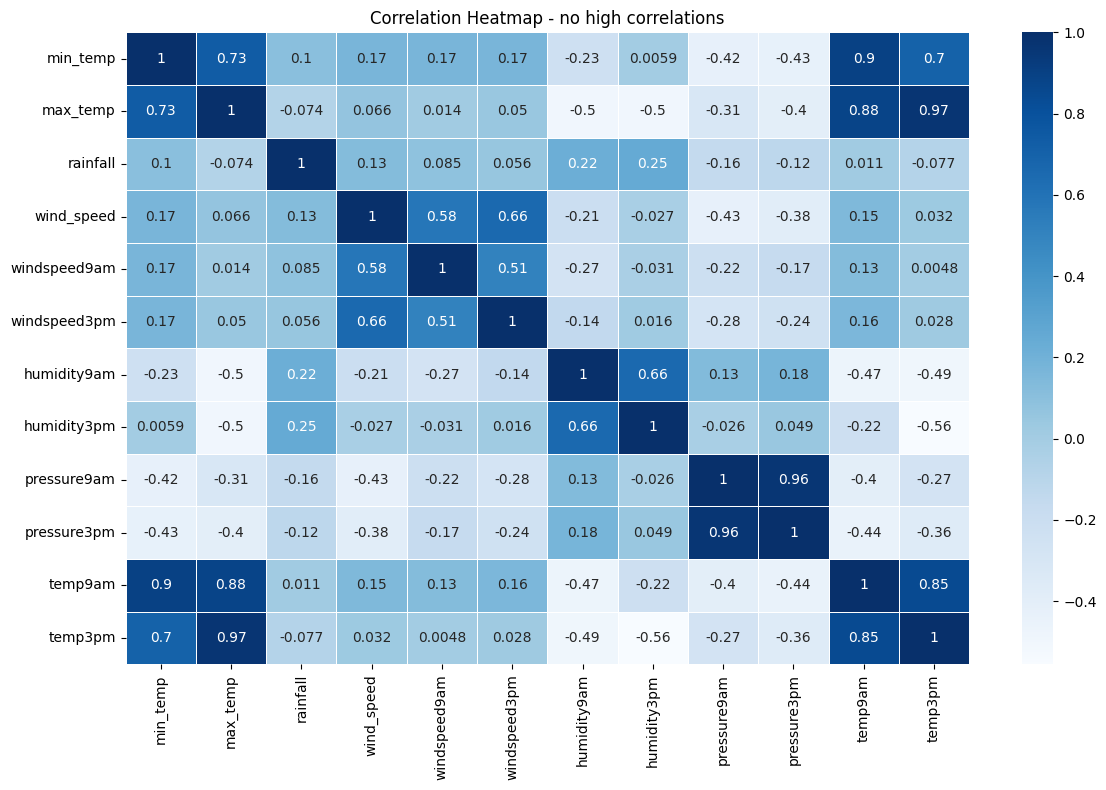

In [175]:
plt.figure(figsize=(12,8),dpi=100)
sns.heatmap(data=df.select_dtypes('number').drop(columns=['rain_tomorrow']).dropna().corr(),annot=True,linewidths=0.5,cmap='Blues')
plt.title("Correlation Heatmap - no high correlations")

plt.tight_layout()
plt.show()

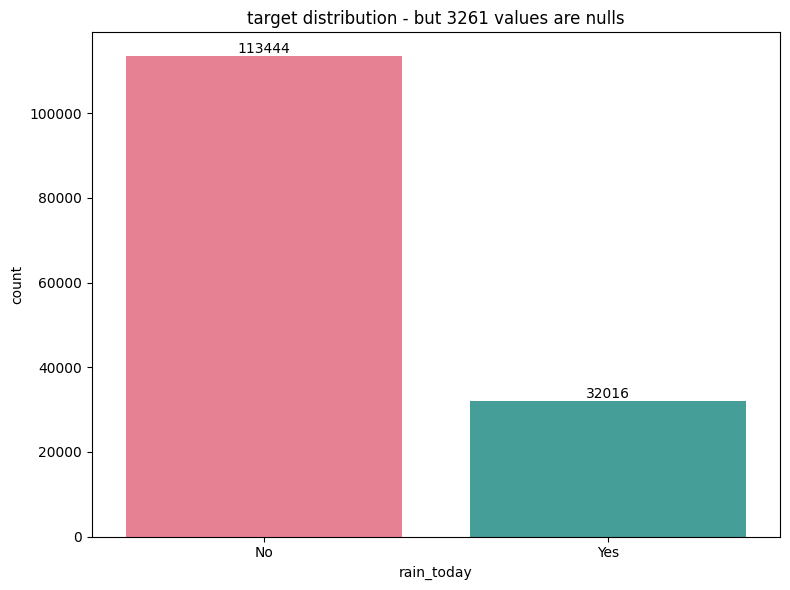

In [18]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("target distribution - but 3261 values are nulls")
ax=sns.countplot(data=df,x="rain_today",palette="husl")
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

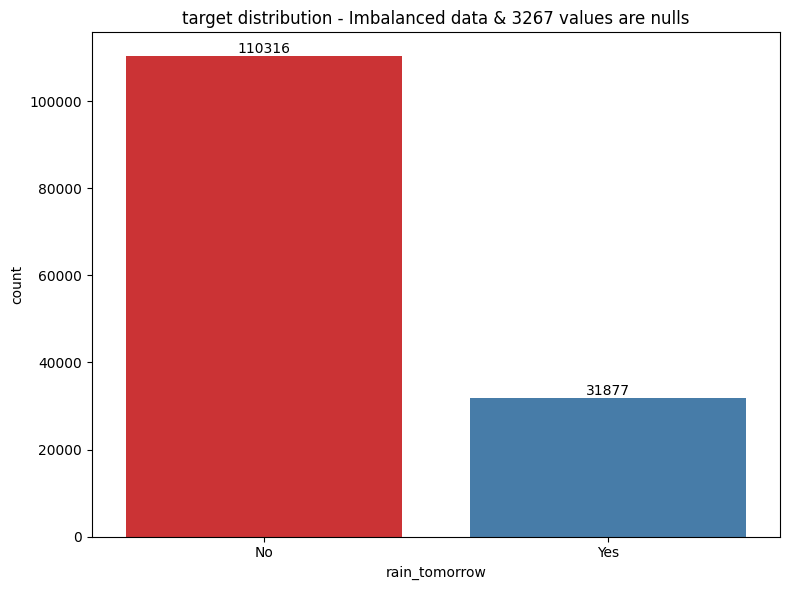

In [24]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("target distribution - Imbalanced data & 3267 values are nulls")
ax=sns.countplot(data=df,x="rain_tomorrow",palette="Set1")
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

In [23]:
len(df[df['rain_tomorrow'].isna()])

3267

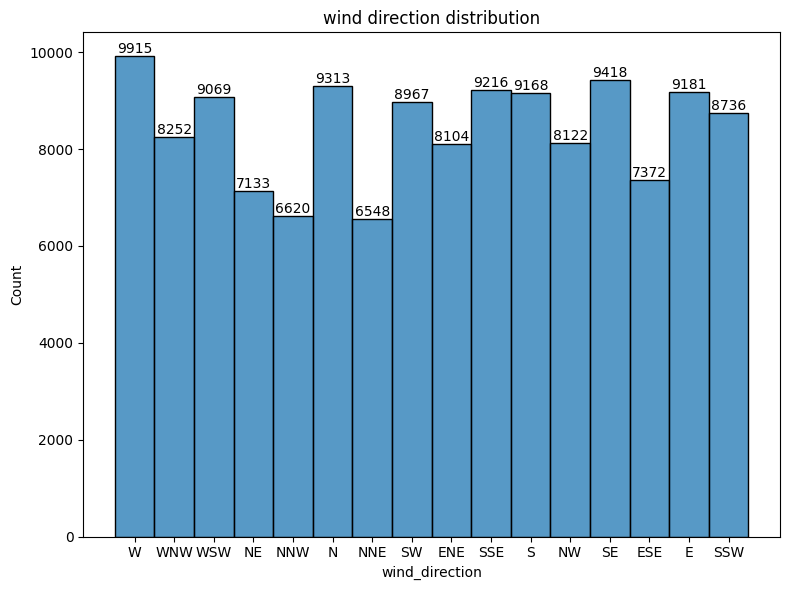

In [30]:
plt.figure(figsize=(8,6),dpi=100)
ax=sns.histplot(data=df,x="wind_direction")
plt.title("wind direction distribution")
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

In [31]:
len(df[df['wind_direction'].isna()])

10326

# KNN imputer null model

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
df_today=df[['rainfall','windspeed9am','windspeed3pm','humidity9am','humidity3pm','pressure9am'
             ,'pressure3pm','temp9am','temp3pm','rain_today']].dropna()

X=df_today.drop(columns=['rain_today'])
y=df_today['rain_today']

X_train,X_val,y_train,y_val=split(X,y,test_size=0.25,random_state=42)

In [38]:
def knn_elbow(X_train,X_val,y_train,y_val):
    """knn elbow method"""
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_val=scaler.transform(X_val)
    
    error_list=[]
    for i in range(2,20):
        knn=KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_val)
        
        error=1-accuracy_score(y_pred,y_val)
        error_list.append(error)
        
    return error_list

error_list=knn_elbow(X_train,X_val,y_train,y_val)
   

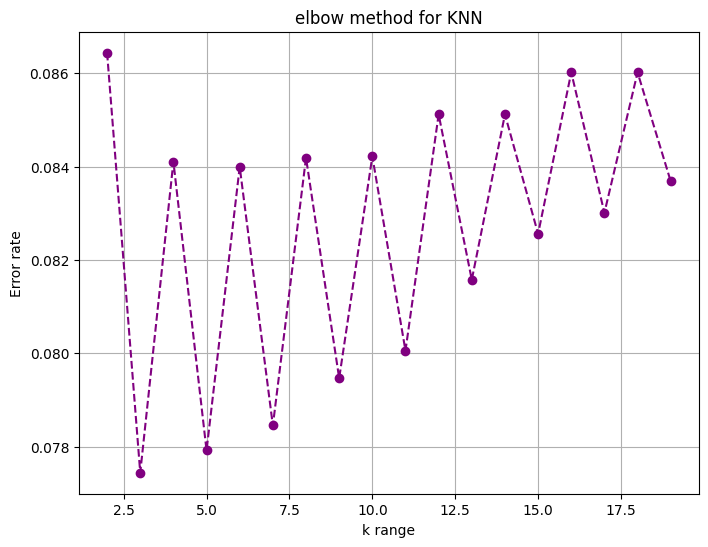

In [153]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(range(2,20),error_list,'o--', color='purple')
plt.title('elbow method for KNN')
plt.xlabel('k range')
plt.ylabel('Error rate')
plt.grid()
plt.show()

In [39]:
scaler=StandardScaler()
knn=KNeighborsClassifier(n_neighbors=3)

knn_pipe=Pipeline(steps=[('scaler',scaler),('knn',knn)])

#this step isn't necessery
#X_train_transformed = knn_pipe.named_steps['scaler'].fit_transform(X_train)
#X_val_transformed = knn_pipe.named_steps['scaler'].transform(X_val)

knn_pipe.fit(X_train,y_train)
y_pred=knn_pipe.predict(X_val)

In [9]:
df['rain_today'].isnull().sum()

np.int64(3261)

In [40]:
X_na=df[['rainfall','windspeed9am','windspeed3pm','humidity9am','humidity3pm','pressure9am'
             ,'pressure3pm','temp9am','temp3pm']][df['rain_today'].isnull()]

na_pred=knn_pipe.predict(X_na)

#rain_today_na_imputer
df['rain_today'][df['rain_today'].isnull()]=na_pred


# PCA

In [16]:
from sklearn.decomposition import PCA,KernelPCA

In [12]:
def pca_elbow_component_metric(data):
    """evaluate and plot dimension reduction expectation"""
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(data)
    
    var_explained_ratio=[]
    for n in range(1,len(data.columns)+1):
        my_pca=PCA(n_components=n)
        my_pca.fit(scaled_data)

        var_explained_ratio.append(np.sum(my_pca.explained_variance_ratio_))
    
    return var_explained_ratio


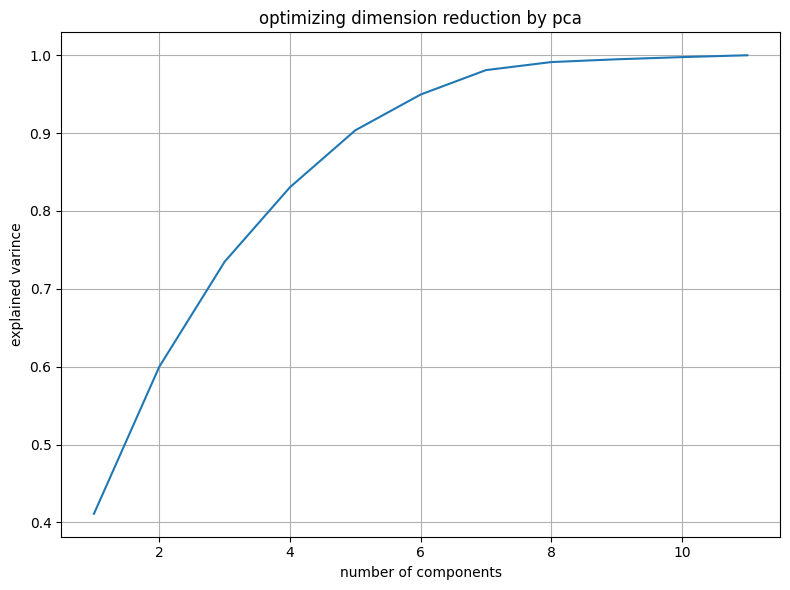

In [98]:
expanded_data=df[['rainfall','windspeed9am','windspeed3pm','humidity9am','humidity3pm','pressure9am','pressure3pm'
                  ,'temp9am','temp3pm','min_temp','max_temp']]
var_explained_ratio_list=pca_elbow_component_metric(expanded_data)

plt.figure(figsize=(8,6),dpi=100)
plt.plot(range(1,len(var_explained_ratio_list) +1 ),var_explained_ratio_list)
plt.title("optimizing dimension reduction by pca")
plt.xlabel("number of components")
plt.ylabel("explained varince")
plt.grid(True)
plt.tight_layout()
plt.show()

# PREPROCESSING

In [17]:
def dimension_deduction(df):
    #separating the df apart
    sep_data=df[['wind_direction' ,'rain_today','rain_tomorrow']]
    pca_data=df.drop(columns=['wind_direction','rain_today','rain_tomorrow'],axis=1)
    
    #standarrize the data
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(pca_data)
    #dimension deduction with pca from 10 to 5 features 
    my_pca=PCA(n_components=6,random_state=42)
    shorten_data=my_pca.fit_transform(scaled_data)
    df_pca=pd.DataFrame(shorten_data)
    
    #concatenate the data 
    final_data=pd.concat([sep_data,df_pca],axis=1, ignore_index=True, sort=False).rename(columns=
            {0:'wind_direction',1:'rain_today',2:'rain_tomorrow',
             3:'feature_1',4:'feature_2',5:'feature_3',6:'feature_4',7:'feature_5',8:'feature_6'})
    
    return final_data

class myOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
        
    def fit(self,X,y=None):
        self.ohe.fit(X.select_dtypes("object"))
        return self
    
    
    def transform(self,X):
        object_transformed_table=pd.DataFrame(self.ohe.transform(X.select_dtypes("object")))
        numerics_table=X.select_dtypes("number")
        output=np.concatenate([object_transformed_table,numerics_table],axis=1)
        
        return output
    
        
    def get_features_name(self):
        return self.ohe
    


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def prepare_data_with_nulls_at_bottom(df, target_column, test_size=0.25, random_state=42):
    # Sort the dataframe so that nulls in the target column are at the bottom
    df_sorted = df.sort_values(by=target_column, na_position='last').reset_index(drop=True)
    
    # Find the index where null values start
    null_start_index = df_sorted[target_column].last_valid_index() + 1
    
    # Split the data
    df_non_null = df_sorted.iloc[:null_start_index]
    df_null = df_sorted.iloc[null_start_index:]
    
    # Split non-null data into features (X) and target (y)
    X_non_null = df_non_null.drop(columns=[target_column])
    y_non_null = df_non_null[target_column]
    
    # Split non-null data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_non_null, y_non_null, 
                                                      test_size=test_size, 
                                                      random_state=random_state)
    
    # Prepare the null data for later prediction
    X_null = df_null.drop(columns=[target_column])
    
    return X_train, X_val, y_train, y_val, X_null




In [6]:
#send full data to pca method
df_pca=dimension_deduction(df)

#split train and test
X_train, X_val, y_train, y_val, X_null = prepare_data_with_nulls_at_bottom(df_pca, 'rain_tomorrow')

#onehotEncoding
my_ohe=myOneHotEncoding()
X_train_model=my_ohe.fit_transform(X_train)
X_val_model=my_ohe.transform(X_val)
X_null_model=my_ohe.transform(X_null)
print(f"X_train_model shape :{X_train_model.shape}\nX_val_model shape{X_val_model.shape}")

X_train_model shape :(106644, 26)
X_val_model shape(35549, 26)


# Model

### Xgboost

In [41]:
from xgboost import XGBClassifier

xgb=XGBClassifier(n_estimators=100)


#set the hyperparameters
learning_rate=[0.01,0.05,0.1]
max_depth=[2,3,5,7]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
subsample=[0.5,0.75,0.9]
reg_lambda=np.linspace(0.1,1,20)
min_child_weight=[1,3,5]

model_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'max_features': max_features,
            'reg_lambda':reg_lambda,
            'min_child_weight':min_child_weight}


rand_model=RandomizedSearchCV(estimator=xgb,param_distributions=model_params,n_iter=50,scoring='f1',random_state=42,cv=4)

In [180]:
rand_model.fit(X_train_model,y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_features': [0.25, 0.5, 0.75, 1],
                                        'min_child_weight': [1, 3, 5],
                                        'reg_lambda': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.75, 0.9]},
                   random_state=42, scoring='f1')

In [181]:
rand_model.best_params_

{'subsample': 0.75,
 'scale_pos_weight': 3,
 'reg_lambda': np.float64(0.6210526315789474),
 'min_child_weight': 3,
 'max_features': 0.25,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.4}

In [182]:
y_pred=rand_model.predict(X_val_model)
print(classification_report(y_pred=y_pred,y_true=y_val))

              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86     27637
         1.0       0.53      0.72      0.61      7912

    accuracy                           0.80     35549
   macro avg       0.72      0.77      0.74     35549
weighted avg       0.83      0.80      0.81     35549



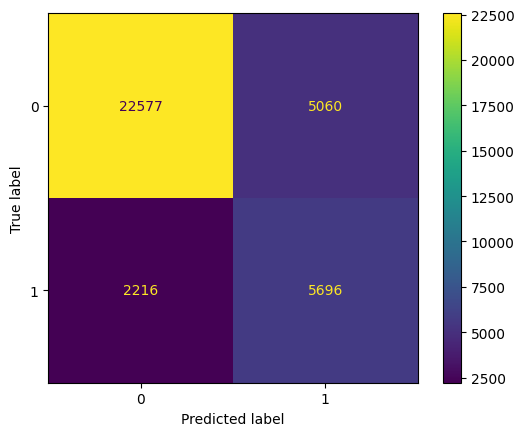

In [183]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_val, labels=rand_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rand_model.classes_)
disp.plot()
plt.show()

In [188]:
rand_model.predict(X_null_model)

array([0, 0, 0, ..., 1, 0, 0])

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [27]:
def rf_weights_optimizer(X_train,y_train,X_val,y_val):
    """class_weight plot do like an elbow method to find the optimization"""
    weights_list=[]
    for i in np.linspace(0,1,25):
        rf=RandomForestClassifier(random_state=42,class_weight={0:1-i,1:i})
        
        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_val)
        
        score=f1_score(y_val,y_pred)
        weights_list.append(score)
        
    return weights_list
    

weight_score_list=rf_weights_optimizer(X_train_model,y_train,X_val_model,y_val)

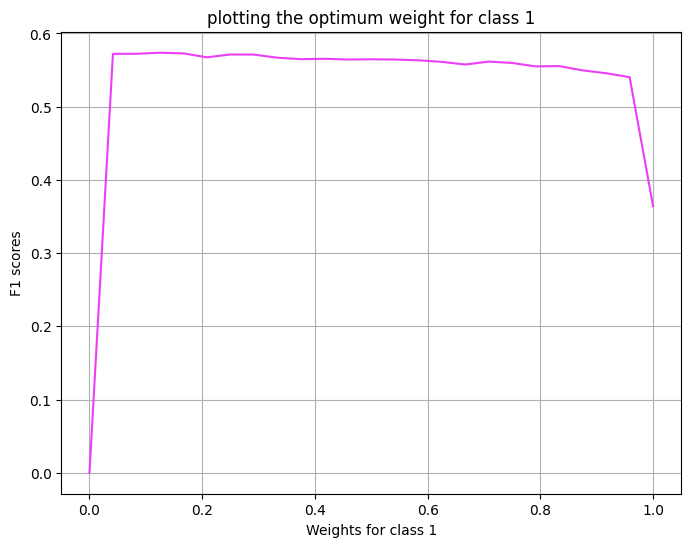

In [30]:
plt.figure(figsize=(8,6),dpi=100)
sns.lineplot(x=np.linspace(0,1,25),y=weight_score_list,color='#ED3EF7')
plt.title('plotting the optimum weight for class 1')
plt.xlabel('Weights for class 1')
plt.ylabel('F1 scores')
plt.grid()
plt.show()

In [32]:
rf=RandomForestClassifier(n_estimators=100,max_samples=0.5, random_state=42)

criterion=['gini','entropy']
max_depth=[3,5,7,10]
max_features=['sqrt','log2']
min_samples_split=[2,3,4]

params={'criterion': criterion,
        'max_depth' : max_depth,
        'min_samples_split': min_samples_split,
        'max_features':max_features }

grid_model=GridSearchCV(rf,params,cv=4, scoring='f1')

In [33]:
grid_model.fit(X_train_model,y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_samples=0.5, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1')

In [34]:
grid_model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2}

In [35]:
y_pred=grid_model.predict(X_val_model)
print(classification_report(y_pred=y_pred,y_true=y_val))

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     27637
         1.0       0.71      0.42      0.53      7912

    accuracy                           0.83     35549
   macro avg       0.78      0.69      0.71     35549
weighted avg       0.82      0.83      0.82     35549



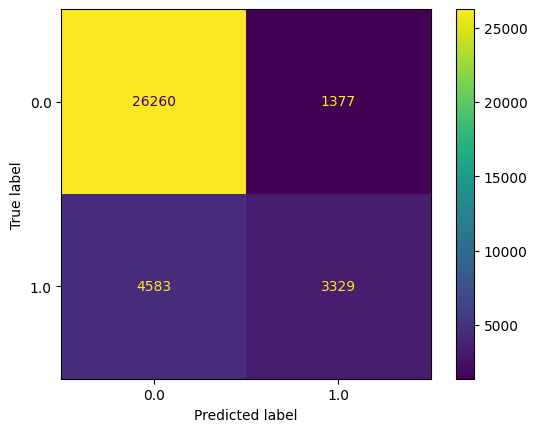

In [36]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_val, labels=grid_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_model.classes_)
disp.plot()
plt.show()

In [39]:
grid_model.predict(X_null_model)

array([0., 0., 0., ..., 0., 0., 0.])

Let's combine both models and try to optimize the results 

## Voter classifier

In [42]:
from sklearn.ensemble import VotingClassifier


voter_model=VotingClassifier(estimators=[
        ('lr', rand_model), ('rf', grid_model)], voting='soft')

In [43]:
voter_model.fit(X_train_model,y_train)

VotingClassifier(estimators=[('lr',
                              RandomizedSearchCV(cv=4,
                                                 estimator=XGBClassifier(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importance_type=None,
                                                                         interac...
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                                                                      'scale_pos_weight': [1,
                                                                                           3,
                                                                                           5],
                                                                      'subsample': [0.5,
                                                                                    0.75,
                                                                                    0.9]},
                                                 random_state=42,
                                                 scoring='f1')),
                             ('rf',
                              GridSearchCV(cv=4,
                                           estimator=RandomForestClassifier(max_samples=0.5,
                                                                            random_state=42),
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [3, 5, 7,
                                                                     10],
                                                       'max_features': ['sqrt',
                                                                        'log2'],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             4]},
                                           scoring='f1'))],
                 voting='soft')

In [44]:
y_pred=voter_model.predict(X_val_model)
print(classification_report(y_pred=y_pred,y_true=y_val))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     27637
         1.0       0.61      0.59      0.60      7912

    accuracy                           0.83     35549
   macro avg       0.75      0.74      0.75     35549
weighted avg       0.82      0.83      0.83     35549



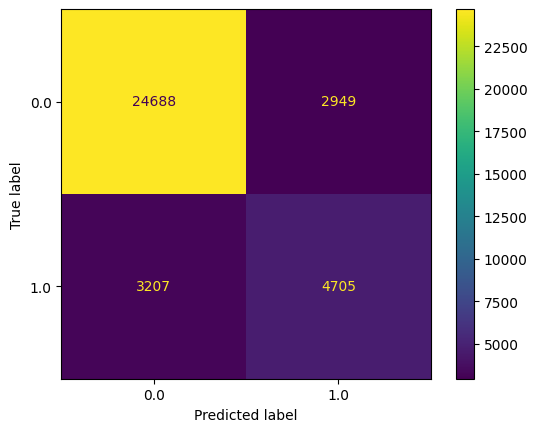

In [45]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_val, labels=voter_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=voter_model.classes_)
disp.plot()
plt.show()